# Continual Learning Experiment 
-----------------------------
### WARNING : This is NOT our benchmark. This is a proof of concept. For our benchmark on adversarial attacks, please refer to benchmark.ipynb

In [1]:
from src.bayes.BayesianModel import BayesianModel
from src.optimizers.SAMTrainer import SAMTrainer
from src.optimizers.SimpleTrainer import SimpleTrainer
%load_ext autoreload
%autoreload 2
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

#### Loading Modules

In [2]:
import torch
from src.utils import dataset
from matplotlib import pyplot as plt
from src.continual_learning.CertifiedPostTrainer import CertifiedPostTrainer
from src.optimizers import interval_narrowers
from src.optimizers.ConstrainedVolumeMultiphaseTrainer import ConstrainedVolumeMultiphaseTrainer
from src.optimizers.HypercubeTrainer import HypercubeTrainer
from src.utils.evaluation import evaluate_accuracy
from src.cert import Safebox
from torch.utils.data import DataLoader, Dataset

#### Utils and Constants

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
def display_dataset(dataset):
    fig, axs = plt.subplots(1,10)
    fig.set_figwidth(15)
    for i in range(10):
        axs[i].set_axis_off()
        axs[i].imshow(dataset[i][0].numpy().reshape((28,28)), cmap="gray")

In [5]:
def get_model(output_dim=10):
    """Returns a simple CNN model."""
    model = torch.nn.Sequential(
        torch.nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(8, 1, kernel_size=5, stride=1, padding=1),
        torch.nn.ReLU(),
        torch.nn.Flatten(),
        torch.nn.Linear(576, output_dim),
    ).to(DEVICE)
    return model

def certify_accuracy(dataset: Dataset, bound_model: torch.nn.Sequential, device="cpu") -> float:
    X, y = next(iter(DataLoader(dataset, batch_size=len(dataset), shuffle=True)))
    X, y, = X.to(device), y.to(device)
    bound_model.eval()
    with torch.no_grad():
        return Safebox.min_acc(y, bound_model(X.unsqueeze(-1).expand(*X.shape, 2))).item()


### MNIST Experiment
---------
In this setup we learn first to classify between digits 0 and 1 and then learn to classify between digits 6 and 7 using the same network. We do not have access to the previous dataset when doing finetuning.

Digit 01 Train Dataset Size:  10132
Digit 01 Test Dataset Size:  2533
Digit 01 Validation Dataset Size:  2115
Digit 67 Train Dataset Size:  9746
Digit 67 Test Dataset Size:  2437
Digit 67 Validation Dataset Size:  1986


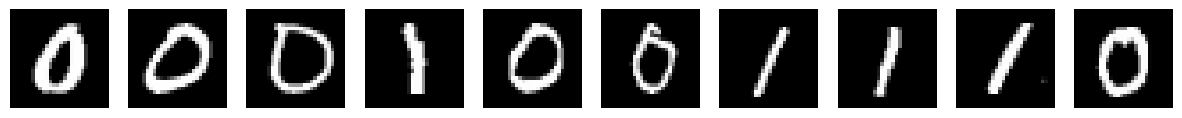

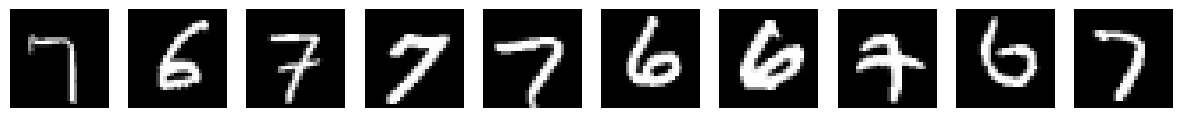

In [6]:
# Setting random seeds for reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

mnist_train_test, mnist_val = dataset.get_mnist_dataset(root="./data")
digit_01_train_test, digit01_val = dataset.filter_labels(mnist_train_test, [0,1]), dataset.filter_labels(mnist_val, [0,1])
digit67_train_test, digit67_val = dataset.filter_labels(mnist_train_test, [6,7]), dataset.filter_labels(mnist_val, [6,7])

digit01_train, digit01_test = dataset.split_dataset(digit_01_train_test, split_proportion=0.8)
digit67_train, digit67_test = dataset.split_dataset(digit67_train_test, split_proportion=0.8)
digit67_train = dataset.map_labels(digit67_train, {6:0, 7:1})
digit67_val = dataset.map_labels(digit67_val, {6:0, 7:1})
digit67_test = dataset.map_labels(digit67_test, {6:0, 7:1})
print("Digit 01 Train Dataset Size: ", len(digit01_train))
print("Digit 01 Test Dataset Size: ", len(digit01_test))
print("Digit 01 Validation Dataset Size: ", len(digit01_val))
display_dataset(digit01_train)
print("Digit 67 Train Dataset Size: ", len(digit67_train))
print("Digit 67 Test Dataset Size: ", len(digit67_test))
print("Digit 67 Validation Dataset Size: ", len(digit67_val))
display_dataset(digit67_train)

In [7]:
# Setting random seeds for reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

h_model_mnist = get_model(output_dim=2)
optimizer_mnist = HypercubeTrainer(h_model_mnist, device=DEVICE)
multiphase_trainer_mnist = ConstrainedVolumeMultiphaseTrainer(
    optimizer_mnist, 
    inflate_function=interval_narrowers.inflate_multiplier(1.5),
    narrow_function=interval_narrowers.narrower_halver(0.5),
    starting_value=1e-4*0.5, 
    min_acc_limit=0.78,
    quiet=False
)
multiphase_trainer_mnist.train(
    16, digit01_val,
    digit01_train, digit01_val, loss_obj=0.0, max_iters=500, batch_size=64, lr=1e-3,
    n_iter_eval_stop = 1000000,
              hard_min_loss_stop = 2.2
)

========== Started Multiphase Trainer for 16 phases ==========
First time train is called. Initial training phase started with volume 5e-05.


100%|██████████| 500/500 [00:21<00:00, 22.74it/s, loss=0.0002, min_val_acc=0.999]


=> Initial center accuracy is 0.9990543723106384
-> Starting phase 15
-> Current Volume interval : [5e-05, INFINITY]


100%|██████████| 500/500 [00:21<00:00, 23.54it/s, loss=0.0016, min_val_acc=1]    


-> Phase done
-> Center Accuracy is 0.9995272159576416.
-> Generalization is above minimum accuracy by 0.21952721595764157.!
-> Starting phase 15
-> Current Volume interval : [7.5e-05, INFINITY]


100%|██████████| 500/500 [00:21<00:00, 23.32it/s, loss=0, min_val_acc=1]         


-> Phase done
-> Center Accuracy is 0.9995272159576416.
-> Generalization is above minimum accuracy by 0.21952721595764157.!
-> Starting phase 15
-> Current Volume interval : [0.0001125, INFINITY]


100%|██████████| 500/500 [00:21<00:00, 23.46it/s, loss=0, min_val_acc=1]         


-> Phase done
-> Center Accuracy is 0.9995272159576416.
-> Generalization is above minimum accuracy by 0.21952721595764157.!
-> Starting phase 15
-> Current Volume interval : [0.00016875, INFINITY]


100%|██████████| 500/500 [00:21<00:00, 22.98it/s, loss=0, min_val_acc=0.999]     


-> Phase done
-> Center Accuracy is 0.9995272159576416.
-> Generalization is above minimum accuracy by 0.21952721595764157.!
-> Starting phase 15
-> Current Volume interval : [0.00025312, INFINITY]


100%|██████████| 500/500 [00:21<00:00, 23.39it/s, loss=0, min_val_acc=0.999]     


-> Phase done
-> Center Accuracy is 0.9990543723106384.
-> Generalization is above minimum accuracy by 0.2190543723106384.!
-> Starting phase 15
-> Current Volume interval : [0.00037969, INFINITY]


100%|██████████| 500/500 [00:21<00:00, 23.25it/s, loss=0, min_val_acc=0.998]     


-> Phase done
-> Center Accuracy is 0.99858158826828.
-> Generalization is above minimum accuracy by 0.21858158826828.!
-> Starting phase 15
-> Current Volume interval : [0.00056953, INFINITY]


100%|██████████| 500/500 [00:21<00:00, 23.58it/s, loss=0, min_val_acc=0.999]     


-> Phase done
-> Center Accuracy is 0.9995272159576416.
-> Generalization is above minimum accuracy by 0.21952721595764157.!
-> Starting phase 15
-> Current Volume interval : [0.0008543, INFINITY]


100%|██████████| 500/500 [00:20<00:00, 23.93it/s, loss=0, min_val_acc=0.998]     


-> Phase done
-> Center Accuracy is 0.9990543723106384.
-> Generalization is above minimum accuracy by 0.2190543723106384.!
-> Starting phase 15
-> Current Volume interval : [0.00128145, INFINITY]


100%|██████████| 500/500 [00:20<00:00, 24.22it/s, loss=0, min_val_acc=0.999]     


-> Phase done
-> Center Accuracy is 0.9990543723106384.
-> Generalization is above minimum accuracy by 0.2190543723106384.!
-> Starting phase 15
-> Current Volume interval : [0.00192217, INFINITY]


100%|██████████| 500/500 [00:20<00:00, 24.21it/s, loss=0, min_val_acc=0.998]     


-> Phase done
-> Center Accuracy is 0.9990543723106384.
-> Generalization is above minimum accuracy by 0.2190543723106384.!
-> Starting phase 15
-> Current Volume interval : [0.00288325, INFINITY]


100%|██████████| 500/500 [00:20<00:00, 23.98it/s, loss=0, min_val_acc=0.996]     


-> Phase done
-> Center Accuracy is 0.9995272159576416.
-> Generalization is above minimum accuracy by 0.21952721595764157.!
-> Starting phase 15
-> Current Volume interval : [0.00432488, INFINITY]


100%|██████████| 500/500 [00:21<00:00, 23.74it/s, loss=0, min_val_acc=0.997]     


-> Phase done
-> Center Accuracy is 1.0.
-> Generalization is above minimum accuracy by 0.21999999999999997.!
-> Starting phase 15
-> Current Volume interval : [0.00648732, INFINITY]


100%|██████████| 500/500 [00:21<00:00, 23.67it/s, loss=0, min_val_acc=0.995]     


-> Phase done
-> Center Accuracy is 0.9995272159576416.
-> Generalization is above minimum accuracy by 0.21952721595764157.!
-> Starting phase 15
-> Current Volume interval : [0.00973098, INFINITY]


100%|██████████| 500/500 [00:20<00:00, 23.82it/s, loss=0, min_val_acc=0.992]     


-> Phase done
-> Center Accuracy is 1.0.
-> Generalization is above minimum accuracy by 0.21999999999999997.!
-> Starting phase 15
-> Current Volume interval : [0.01459646, INFINITY]


100%|██████████| 500/500 [00:21<00:00, 23.73it/s, loss=0.132, min_val_acc=0.984] 


-> Phase done
-> Center Accuracy is 1.0.
-> Generalization is above minimum accuracy by 0.21999999999999997.!
Training succeeded !


True

In [8]:
bound_model_mnist = multiphase_trainer_mnist.result()
center_model_mnist = Safebox.bmodelToModel(bound_model_mnist).to(DEVICE)
print(f"Certified Accuracy of bound model on original task {certify_accuracy(digit01_test, bound_model_mnist, device=DEVICE)}")
print(f"Initial center model accuracy on new task {evaluate_accuracy(digit67_test, center_model_mnist, num_samples=len(digit67_test), device=DEVICE)}")
post_trainer_mnist = CertifiedPostTrainer(bound_model_mnist, device=DEVICE)

post_trainer_mnist.train(
    digit67_train,
    digit67_val, loss_obj=0.0, max_iters=700, batch_size=64, lr=1e-3,
    n_iter_eval_stop = 10000000000,
)
fine_tuned_model_mnist = post_trainer_mnist.result()
print(f"Final Fine-Tuned model accuracy on new task {evaluate_accuracy(digit67_test, fine_tuned_model_mnist, num_samples=len(digit67_test), device=DEVICE)}")
print(f"Final Fine-Tuned model accuracy on original task {evaluate_accuracy(digit01_test, fine_tuned_model_mnist, num_samples=len(digit01_test), device=DEVICE)}")

Certified Accuracy of bound model on original task 0.9774969816207886
Initial center model accuracy on new task 0.706196129322052


100%|██████████| 700/700 [00:16<00:00, 41.59it/s, loss=3.99, val_acc=0.823] 


Final Fine-Tuned model accuracy on new task 0.791136622428894
Final Fine-Tuned model accuracy on original task 0.9992104172706604


item 01 Train Dataset Size:  9600
item 01 Test Dataset Size:  2400
item 01 Validation Dataset Size:  2000
item 23 Train Dataset Size:  9600
item 23 Test Dataset Size:  2400
item 23 Validation Dataset Size:  2000


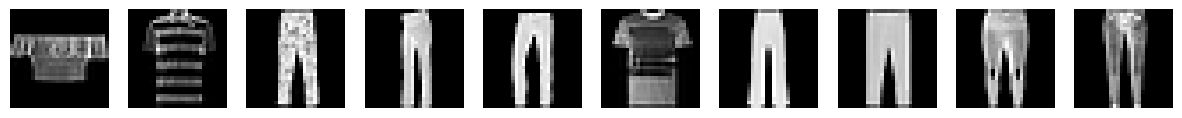

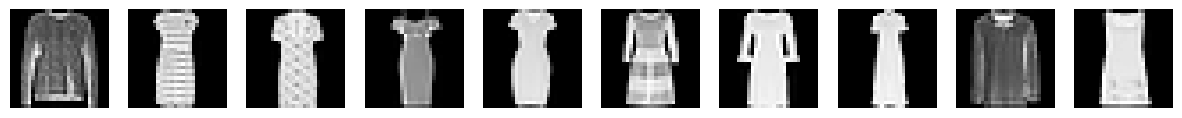

In [9]:
# Setting random seeds for reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

fashion_mnist_train_test, fashion_mnist_val = dataset.get_fashion_mnist_dataset(root="./data")
item_01_train_test, item01_val = dataset.filter_labels(fashion_mnist_train_test, [0,1]), dataset.filter_labels(fashion_mnist_val, [0,1])
item_23_train_test, item23_val = dataset.filter_labels(fashion_mnist_train_test, [2,3]), dataset.filter_labels(fashion_mnist_val, [2,3])

item01_train, item01_test = dataset.split_dataset(item_01_train_test, split_proportion=0.8)
item23_train, item23_test = dataset.split_dataset(item_23_train_test, split_proportion=0.8)
item23_train = dataset.map_labels(item23_train, {2:0, 3:1})
item23_val = dataset.map_labels(item23_val, {2:0, 3:1})
item23_test = dataset.map_labels(item23_test, {2:0, 3:1})
print("item 01 Train Dataset Size: ", len(item01_train))
print("item 01 Test Dataset Size: ", len(item01_test))
print("item 01 Validation Dataset Size: ", len(item01_val))
display_dataset(item01_train)
print("item 23 Train Dataset Size: ", len(item23_train))
print("item 23 Test Dataset Size: ", len(item23_test))
print("item 23 Validation Dataset Size: ", len(item23_val))
display_dataset(item23_train)

In [10]:
# Setting random seeds for reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

h_model_fashion = get_model(output_dim=2)
optimizer_fashion = HypercubeTrainer(h_model_fashion, device=DEVICE)
multiphase_trainer_fashion = ConstrainedVolumeMultiphaseTrainer(
    optimizer_fashion, 
    inflate_function=interval_narrowers.inflate_multiplier(1.5),
    narrow_function=interval_narrowers.narrower_halver(0.5),
    starting_value=1e-4*0.5, 
    min_acc_limit=0.78,
    quiet=False
)
multiphase_trainer_fashion.train(
    16, item01_val,
    item01_train, item01_val, loss_obj=0.0, max_iters=500, batch_size=64, lr=1e-3,
    n_iter_eval_stop = 1000000,
              hard_min_loss_stop = 2.2
)

========== Started Multiphase Trainer for 16 phases ==========
First time train is called. Initial training phase started with volume 5e-05.


100%|██████████| 500/500 [00:21<00:00, 23.09it/s, loss=0.0401, min_val_acc=0.979]


=> Initial center accuracy is 0.9869999885559082
-> Starting phase 15
-> Current Volume interval : [5e-05, INFINITY]


100%|██████████| 500/500 [00:21<00:00, 22.86it/s, loss=0.0437, min_val_acc=0.982]


-> Phase done
-> Center Accuracy is 0.9890000224113464.
-> Generalization is above minimum accuracy by 0.2090000224113464.!
-> Starting phase 15
-> Current Volume interval : [7.5e-05, INFINITY]


100%|██████████| 500/500 [00:21<00:00, 22.95it/s, loss=0.0109, min_val_acc=0.989]


-> Phase done
-> Center Accuracy is 0.9904999732971191.
-> Generalization is above minimum accuracy by 0.21049997329711911.!
-> Starting phase 15
-> Current Volume interval : [0.0001125, INFINITY]


100%|██████████| 500/500 [00:21<00:00, 22.79it/s, loss=0.0344, min_val_acc=0.986]


-> Phase done
-> Center Accuracy is 0.9890000224113464.
-> Generalization is above minimum accuracy by 0.2090000224113464.!
-> Starting phase 15
-> Current Volume interval : [0.00016875, INFINITY]


100%|██████████| 500/500 [00:28<00:00, 17.57it/s, loss=0.0473, min_val_acc=0.987]


-> Phase done
-> Center Accuracy is 0.9894999861717224.
-> Generalization is above minimum accuracy by 0.20949998617172239.!
-> Starting phase 15
-> Current Volume interval : [0.00025312, INFINITY]


100%|██████████| 500/500 [00:21<00:00, 23.51it/s, loss=0.0005, min_val_acc=0.987]


-> Phase done
-> Center Accuracy is 0.9915000200271606.
-> Generalization is above minimum accuracy by 0.21150002002716062.!
-> Starting phase 15
-> Current Volume interval : [0.00037969, INFINITY]


100%|██████████| 500/500 [00:21<00:00, 23.42it/s, loss=0.002, min_val_acc=0.986] 


-> Phase done
-> Center Accuracy is 0.9915000200271606.
-> Generalization is above minimum accuracy by 0.21150002002716062.!
-> Starting phase 15
-> Current Volume interval : [0.00056953, INFINITY]


100%|██████████| 500/500 [00:21<00:00, 22.81it/s, loss=0.0172, min_val_acc=0.986]


-> Phase done
-> Center Accuracy is 0.9894999861717224.
-> Generalization is above minimum accuracy by 0.20949998617172239.!
-> Starting phase 15
-> Current Volume interval : [0.0008543, INFINITY]


100%|██████████| 500/500 [00:21<00:00, 23.02it/s, loss=0.0011, min_val_acc=0.985]


-> Phase done
-> Center Accuracy is 0.9909999966621399.
-> Generalization is above minimum accuracy by 0.21099999666213987.!
-> Starting phase 15
-> Current Volume interval : [0.00128145, INFINITY]


100%|██████████| 500/500 [00:22<00:00, 22.59it/s, loss=0.0587, min_val_acc=0.984]


-> Phase done
-> Center Accuracy is 0.9900000095367432.
-> Generalization is above minimum accuracy by 0.21000000953674314.!
-> Starting phase 15
-> Current Volume interval : [0.00192217, INFINITY]


100%|██████████| 500/500 [00:22<00:00, 22.46it/s, loss=0.0054, min_val_acc=0.98] 


-> Phase done
-> Center Accuracy is 0.9900000095367432.
-> Generalization is above minimum accuracy by 0.21000000953674314.!
-> Starting phase 15
-> Current Volume interval : [0.00288325, INFINITY]


100%|██████████| 500/500 [00:22<00:00, 22.70it/s, loss=0.057, min_val_acc=0.975] 


-> Phase done
-> Center Accuracy is 0.9879999756813049.
-> Generalization is above minimum accuracy by 0.2079999756813049.!
-> Starting phase 15
-> Current Volume interval : [0.00432488, INFINITY]


100%|██████████| 500/500 [00:21<00:00, 22.93it/s, loss=0.0763, min_val_acc=0.965]


-> Phase done
-> Center Accuracy is 0.9869999885559082.
-> Generalization is above minimum accuracy by 0.20699998855590818.!
-> Starting phase 15
-> Current Volume interval : [0.00648732, INFINITY]


100%|██████████| 500/500 [00:22<00:00, 22.49it/s, loss=0.0348, min_val_acc=0.955]


-> Phase done
-> Center Accuracy is 0.9860000014305115.
-> Generalization is above minimum accuracy by 0.20600000143051145.!
-> Starting phase 15
-> Current Volume interval : [0.00973098, INFINITY]


100%|██████████| 500/500 [00:21<00:00, 23.21it/s, loss=0.258, min_val_acc=0.933] 


-> Phase done
-> Center Accuracy is 0.9825000166893005.
-> Generalization is above minimum accuracy by 0.2025000166893005.!
-> Starting phase 15
-> Current Volume interval : [0.01459646, INFINITY]


100%|██████████| 500/500 [00:21<00:00, 23.51it/s, loss=0.432, min_val_acc=0.881]


-> Phase done
-> Center Accuracy is 0.9745000004768372.
-> Generalization is above minimum accuracy by 0.19450000047683713.!
Training succeeded !


True

In [11]:
from src.continual_learning.CertifiedPostTrainer import CertifiedPostTrainer

bound_model_fashion = multiphase_trainer_fashion.result()
center_model_fashion = Safebox.bmodelToModel(bound_model_fashion).to(DEVICE)
print(f"Certified Accuracy of bound model on original task {certify_accuracy(item01_test, bound_model_fashion, device=DEVICE)}")
print(f"Initial center model accuracy on new task {evaluate_accuracy(item23_test, center_model_fashion, num_samples=len(item23_test), device=DEVICE)}")
post_trainer_fashion = CertifiedPostTrainer(bound_model_fashion, device=DEVICE)

post_trainer_fashion.train(
    item23_train,
    item23_val, loss_obj=0.0, max_iters=700, batch_size=64, lr=1e-3,
    n_iter_eval_stop = 10000000000,
)
fine_tuned_model_fashion = post_trainer_fashion.result()
print(f"Final Fine-Tuned model accuracy on new task {evaluate_accuracy(item23_test, fine_tuned_model_fashion, num_samples=len(item23_test), device=DEVICE)}")
print(f"Final Fine-Tuned model accuracy on original task {evaluate_accuracy(item01_test, fine_tuned_model_fashion, num_samples=len(item01_test), device=DEVICE)}")

Certified Accuracy of bound model on original task 0.8808333277702332
Initial center model accuracy on new task 0.6387500166893005


100%|██████████| 700/700 [00:17<00:00, 39.07it/s, loss=0.607, val_acc=0.738]


Final Fine-Tuned model accuracy on new task 0.7520833611488342
Final Fine-Tuned model accuracy on original task 0.9754167199134827
